In [3]:
#! pip install -r requirements.txt

In [7]:
import os
import random
import tarfile

import splitfolders
from tqdm import tqdm
import nibabel as nib
from glob import glob as glb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import shutil

from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
import gc

import segmentation_models_pytorch_3d as smp

from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter

%matplotlib inline

print(torch.__version__)

c:\Users\goudj\anaconda3\envs\opencv-env\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\goudj\anaconda3\envs\opencv-env\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\goudj\anaconda3\envs\opencv-env\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update th

2.9.0+cpu


## Comprendre la base de données

The mpMRI scans (multi-parametric) for BraTS-2021 are multiple image volumes under different camera settings such as,  

1) Native T1-weighted (T1),
2) post gadolinium (Gd) contrast T1-weighted (T1Gd),
3) T2-weighted (T2), and
4) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR).

The dataset consists the following four classes or subregions,

* Class 0: Background / Unlabelled
* Class 1: Necrotic Tumor Core
* Class 2: Peritumoral Edematous/ Invaded Tissue
* Class 3: GD-Enhancing Tumor

In [8]:
# Forcer un travail dedeterministe
def seed_everything(SEED):
   np.random.seed(SEED)
   torch.manual_seed(SEED)
   torch.cuda.manual_seed_all(SEED)
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False


def get_default_device():
   gpu_available = torch.cuda.is_available()
   return torch.device('cuda' if gpu_available else 'cpu'), gpu_available

get_default_device()

(device(type='cpu'), False)

In [5]:
def ExtractData(filepath:str, destination:str):

    loaded_file = tarfile.open(filepath)
    loaded_file.extractall(destination)

    print("Done")
    loaded_file.close()

In [6]:
# To be run once
if not os.path.exists("extracted_data"):
    os.mkdir("extracted_data")

In [10]:
filepath = "BraTS2021_Training_Data.tar"
destination = "extracted_data"

# Extract file
ExtractData(filepath, destination)

C:\Users\goudj\AppData\Local\Temp\ipykernel_17644\562633965.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  loaded_file.extractall(destination)


Done


In [11]:
folder_path = [os.path.join(destination, i) for i in os.listdir("extracted_data")]

In [12]:
imgs = []

for i in folder_path:
    imgs.append(glb(i+"/*")) 

print("Done")

Done


In [13]:
sorted_imgs = list(map(sorted, imgs))
sorted_imgs[1]

['extracted_data\\BraTS2021_00000\\BraTS2021_00000_flair.nii.gz',
 'extracted_data\\BraTS2021_00000\\BraTS2021_00000_seg.nii.gz',
 'extracted_data\\BraTS2021_00000\\BraTS2021_00000_t1.nii.gz',
 'extracted_data\\BraTS2021_00000\\BraTS2021_00000_t1ce.nii.gz',
 'extracted_data\\BraTS2021_00000\\BraTS2021_00000_t2.nii.gz']

In [16]:
df = pd.DataFrame(sorted_imgs, columns=["flair", "seg", "t1", "t1ce", "t2"])

df["folder_path"] = folder_path

In [17]:
df = df[["folder_path", "flair", "seg", "t1", "t1ce", "t2"]]

print(df.shape)

df.tail()

(1252, 6)


folder_path  \
1247  extracted_data\BraTS2021_01662   
1248  extracted_data\BraTS2021_01663   
1249  extracted_data\BraTS2021_01664   
1250  extracted_data\BraTS2021_01665   
1251  extracted_data\BraTS2021_01666   

                                                  flair  \
1247  extracted_data\BraTS2021_01662\BraTS2021_01662...   
1248  extracted_data\BraTS2021_01663\BraTS2021_01663...   
1249  extracted_data\BraTS2021_01664\BraTS2021_01664...   
1250  extracted_data\BraTS2021_01665\BraTS2021_01665...   
1251  extracted_data\BraTS2021_01666\BraTS2021_01666...   

                                                    seg  \
1247  extracted_data\BraTS2021_01662\BraTS2021_01662...   
1248  extracted_data\BraTS2021_01663\BraTS2021_01663...   
1249  extracted_data\BraTS2021_01664\BraTS2021_01664...   
1250  extracted_data\BraTS2021_01665\BraTS2021_01665...   
1251  extracted_data\BraTS2021_01666\BraTS2021_01666...   

                                                     t1  \
1247  extracted_data\BraTS2021_01662\BraTS2021_01662...   
1248  extracted_data\BraTS2021_01663\BraTS2021_01663...   
1249  extracted_data\BraTS2021_01664\BraTS2021_01664...   
1250  extracted_data\BraTS2021_01665\BraTS2021_01665...   
1251  extracted_data\BraTS2021_01666\BraTS2021_01666...   

                                                   t1ce  \
1247  extracted_data\BraTS2021_01662\BraTS2021_01662...   
1248  extracted_data\BraTS2021_01663\BraTS2021_01663...   
1249  extracted_data\BraTS2021_01664\BraTS2021_01664...   
1250  extracted_data\BraTS2021_01665\BraTS2021_01665...   
1251  extracted_data\BraTS2021_01666\BraTS2021_01666...   

                                                     t2  
1247  extracted_data\BraTS2021_01662\BraTS2021_01662...  
1248  extracted_data\BraTS2021_01663\BraTS2021_01663...  
1249  extracted_data\BraTS2021_01664\BraTS2021_01664...  
1250  extracted_data\BraTS2021_01665\BraTS2021_01665...  
1251  extracted_data\BraTS2021_01666\BraTS2021_01666...

Le reseaux de nerrone a besion des valeur entre 0 et 1 ou -1 et 1 pour garder entrainement stable. C'est pour cela que nous utilisaons MinMaxScaler() pour mettre nos pixel entre 0 et 1.

In [18]:
scaler = MinMaxScaler()
type_imgs = ['Image flair',  'Mask seg',  'Image t1',  'Image t1ce', 'Image t2']

In [19]:
sample_images = []

#Load the NifTI image using nib.load() and normalize
for i, type_img in enumerate(type_imgs):
    sample_image = nib.load(sorted_imgs[2][i]).get_fdata()
    print(f"{type_img} max value: ", sample_image.max())
    print(f"{type_img} Shape: ", sample_image.shape)

    # Reshape the 3D image to 2D for scaling
    sample_image_flat = sample_image.reshape(-1, 1)
    print(f"ReShape {type_img} for scaling " ,sample_image_flat.shape)

    if i != 1:
        # Apply scaling
        sample_image_scaled = scaler.fit_transform(sample_image_flat)

        # Reshape it back to the original 3D shape
        sample_image_scaled = sample_image_scaled.reshape(sample_image.shape)
    else:
        sample_image_scaled = sample_image

    print("Scaled max value:", sample_image_scaled.max())
    print("Shape ofter scaled Image: ", sample_image_scaled.shape)
    print('\n')
    sample_images.append(sample_image_scaled)

Image flair max value:  2563.0
Image flair Shape:  (240, 240, 155)
ReShape Image flair for scaling  (8928000, 1)
Scaled max value: 1.0
Shape ofter scaled Image:  (240, 240, 155)


Mask seg max value:  4.0
Mask seg Shape:  (240, 240, 155)
ReShape Mask seg for scaling  (8928000, 1)
Scaled max value: 4.0
Shape ofter scaled Image:  (240, 240, 155)


Image t1 max value:  2300.0
Image t1 Shape:  (240, 240, 155)
ReShape Image t1 for scaling  (8928000, 1)
Scaled max value: 1.0
Shape ofter scaled Image:  (240, 240, 155)


Image t1ce max value:  12137.0
Image t1ce Shape:  (240, 240, 155)
ReShape Image t1ce for scaling  (8928000, 1)
Scaled max value: 1.0
Shape ofter scaled Image:  (240, 240, 155)


Image t2 max value:  2217.0
Image t2 Shape:  (240, 240, 155)
ReShape Image t2 for scaling  (8928000, 1)
Scaled max value: 1.0
Shape ofter scaled Image:  (240, 240, 155)




### Gestion des mask de segmentation

* Nombre de class
* Taille du mask
* Visualisation

In [20]:
sample_mask = sample_images[1]
sample_mask = sample_mask.astype(np.uint8)  # values between 0 and 255

print("Unique class in the mask", np.unique(sample_mask))
print("Shape of the mask", sample_mask.shape)

Unique class in the mask [0 1 2 4]
Shape of the mask (240, 240, 155)


<function matplotlib.pyplot.show(close=None, block=None)>

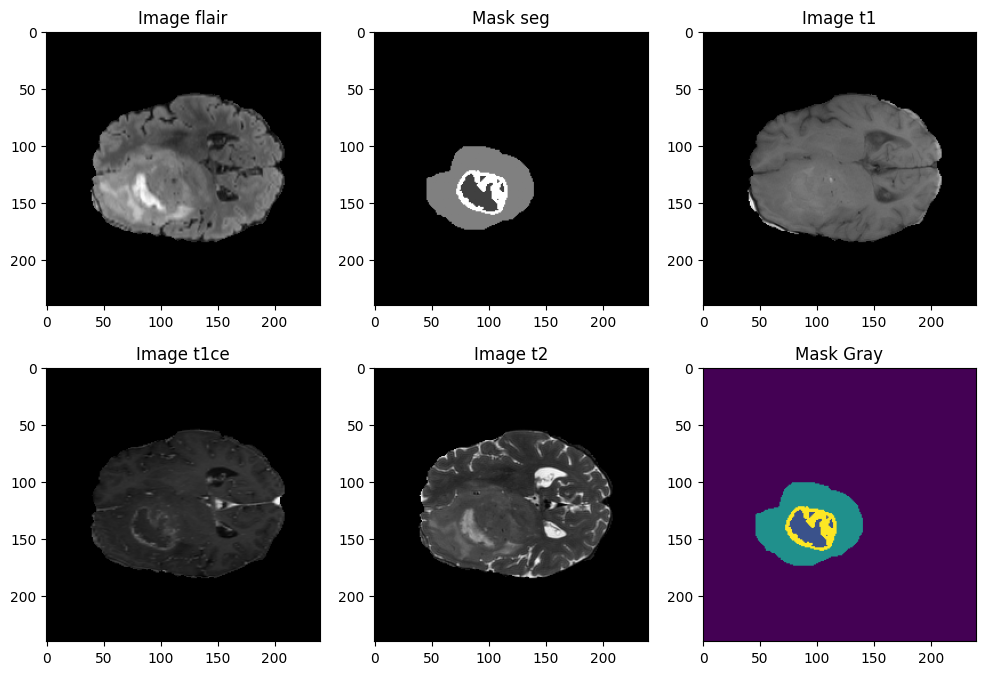

In [22]:
n_slice = random.randint(0, sample_mask.shape[2])  # random slice between 0 - 154
plt.figure(figsize = (12,8))

for i, type_img in enumerate(type_imgs):
    index = 231 + i
    plt.subplot(index)
    plt.imshow(sample_images[i][:,:,n_slice], cmap='gray')
    plt.title(type_img)

plt.subplot(236)
plt.imshow(sample_images[1][:,:,n_slice])
plt.title('Mask Gray')
plt.show

### Tips for training

1) Forme du tensor d'entrainement
   
Pour l'entrainement plus tot que d'entrainé chaque modalité individuel, nous allons leur empiller les uns sur les autres sur le dernier axes. Cela permet de combiner la representation et la richesse d'information disponible à travers les modalités sur l’ensemble de l’analyse cérébrale.

2) Structure de chaque images

Entraîner l'ensemble des données avec les dimensions de l'image d'origine nécessiterait beaucoup de mémoire et n'est pas nécessaire. Par conséquent, une approche optimale consiste à considérer uniquement le ROI. Grâce à des essais et des erreurs, le découpage et le recadrage de la zone comprise entre 56 et 184 environ se sont révélés être un retour sur investissement plus approprié.

3) One hot



In [23]:
combined_x = np.stack(
    [sample_images[0], sample_images[1], sample_images[-1]], axis=3
)  # along the last channel dimension.
print("Shape of Combined x ", combined_x.shape)
# Shape of Combined x  (240, 240, 155, 3)

Shape of Combined x  (240, 240, 155, 3)


In [24]:
combined_x = combined_x[56:184, 56:184, 13:141]
print("Shape after cropping: ", combined_x.shape)

sample_mask_c = sample_mask[56:184,56:184, 13:141]
print("Mask shape after cropping: ", sample_mask_c.shape)

Shape after cropping:  (128, 128, 128, 3)
Mask shape after cropping:  (128, 128, 128)


In [25]:
sample_mask_c = np.where(sample_mask_c == 4, 3, sample_mask_c)
sample_mask_cat  = F.one_hot(torch.tensor(sample_mask_c, dtype = torch.int64), num_classes = 4)

## Traitement du jeu de donnée


La boucle suivante parcourt tous les fichiers provenant de différentes modalités d'IRM, les empile au format multicanal le long de la dernière dimension et les enregistre en tant que fichier .npy. Ici, np.unqiue() renvoie les valeurs de classe uniques et leurs nombres correspondants d'un masque de segmentation.

Pour optimiser le calcul, nous pouvons ignorer ou ignorer les volumes d'image qui contiennent moins de 1 % de pixels hors arrière-plan. Cette stratégie réduit la surcharge de calcul sans sacrifier les fonctionnalités importantes.

In [26]:
df_sampled = df.sample(frac=0.25, random_state=42)

t1ce_list = list(df_sampled["t1ce"])
t2_list = list(df_sampled["t2"])
flair_list = list(df_sampled["t1ce"])
mask_list = list(df_sampled["seg"])

In [27]:

for idx in tqdm(
    range(len(t2_list)), desc="Preparing to stack, crop and save", unit="file"
):
    try:
        temp_image_t1ce = nib.load(t1ce_list[idx]).get_fdata()
        temp_image_t1ce = scaler.fit_transform(
            temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])
        ).reshape(temp_image_t1ce.shape)

        temp_image_t2 = nib.load(t2_list[idx]).get_fdata()
        temp_image_t2 = scaler.fit_transform(
            temp_image_t2.reshape(-1, temp_image_t2.shape[-1])
        ).reshape(temp_image_t2.shape)

        temp_image_flair = nib.load(flair_list[idx]).get_fdata()
        temp_image_flair = scaler.fit_transform(
            temp_image_flair.reshape(-1, temp_image_flair.shape[-1])
        ).reshape(temp_image_flair.shape)

        temp_mask = nib.load(mask_list[idx]).get_fdata()
        temp_mask = np.where(temp_mask == 4, 3, temp_mask)

        temp_combined_images = np.stack(
            [temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3
        )

        temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
        temp_mask = temp_mask[56:184, 56:184, 13:141]

        val, counts = np.unique(temp_mask, return_counts=True)

        # Si le volume est moins de 1% de mask, on ignore
        if (1 - (counts[0] / counts.sum())) > 0.01:
            #         print("Saving Processed Images and Masks")
            temp_mask = F.one_hot(torch.tensor(temp_mask, dtype=torch.long), num_classes=4)
            os.makedirs("BraTS2023_Preprocessed/input_data_3channels/images", exist_ok=True)
            os.makedirs("BraTS2023_Preprocessed/input_data_3channels/masks", exist_ok=True)

            np.save(
                "BraTS2023_Preprocessed/input_data_3channels/images/image_"
                + str(idx)
                + ".npy",
                temp_combined_images,
            )
            np.save(
                "BraTS2023_Preprocessed/input_data_3channels/masks/mask_"
                + str(idx)
                + ".npy",
                temp_mask,
            )

    except Exception as e:
        print(f"❌ Error at index {idx}: {e}")
        continue

Preparing to stack, crop and save: 100%|██████████| 313/313 [12:53<00:00,  2.47s/file]


In [28]:
images_folder = "BraTS2023_Preprocessed/input_data_3channels/images"
print(len(os.listdir(images_folder)))

masks_folder = "BraTS2023_Preprocessed/input_data_3channels/masks"
print(len(os.listdir(masks_folder)))

if os.path.exists(destination):
    shutil.rmtree(destination)
    print(f"{destination} is removed")
else:
    print(f"{destination} doesn't exist")

286
286
extracted_data is removed


Nous utilisons splitfolders.ratio(), nous pouvons diviser en échantillons de formation et de validation dans des répertoires séparés avec un taux de division de test de 0,25.

In [29]:
from pickle import TRUE
input_folder = "BraTS2023_Preprocessed/input_data_3channels/"

output_folder = "BraTS2023_Preprocessed/input_data_128/"

splitfolders.ratio(
    input_folder, output_folder, seed=42, ratio=(0.80, 0.20), group_prefix=None, move=True
)

Copying files: 572 files [00:00, 2107.77 files/s]


In [30]:
# Supprimer les données brutes
if os.path.exists(input_folder):
    shutil.rmtree(input_folder)
    print(f"{input_folder} is removed")
else:
    print(f"{input_folder} doesn't exist")

BraTS2023_Preprocessed/input_data_3channels/ is removed


## Creation pipeline de transformation de données

Pour passer à la préparation finale de l'ensemble de données, nous définirons un ensemble de données PyTorch personnalisé qui gère le chargement des fichiers, les transformations, etc. Comme d'habitude, le __len__ renvoie la longueur totale des fichiers dans la img_list.

In [9]:
class BratsDataset(Dataset):
  def __init__(self, img_dir, mask_dir, normalization=True):
    super().__init__()

    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.img_list = sorted(
        os.listdir(img_dir)
    )  # Ensure sorting to match images and masks
    self.mask_list = sorted(os.listdir(mask_dir))
    self.normalization = normalization

    # If normalization is True, set up a normalization transform
    if self.normalization:
        self.normalizer = transforms.Normalize(
            mean=[0.5], std=[0.5]
        )  # Adjust mean and std based on your data

  def load_file(self, filepath):
    return np.load(filepath)

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, idx):
    image_path = os.path.join(self.img_dir, self.img_list[idx])
    mask_path = os.path.join(self.mask_dir, self.mask_list[idx])
    # Load the image and mask
    image = self.load_file(image_path)
    mask = self.load_file(mask_path)

    # Convert to torch tensors and permute axes to C, D, H, W format (needed for 3D models)
    image = torch.from_numpy(image).permute(3, 2, 0, 1)  # Shape: C, D, H, W
    mask = torch.from_numpy(mask).permute(3, 2, 0, 1)  # Shape: C, D, H, W

    # Normalize the image if normalization is enabled
    if self.normalization:
        image = self.normalizer(image)

    return image, mask

In [10]:
train_img_dir = "BraTS2023_Preprocessed/input_data_128/train/images"
train_mask_dir = "BraTS2023_Preprocessed/input_data_128/train/masks"

val_img_dir = "BraTS2023_Preprocessed/input_data_128/val/images"
val_mask_dir = "BraTS2023_Preprocessed/input_data_128/val/masks"

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

# Initialize datasets with normalization only
train_dataset = BratsDataset(train_img_dir, train_mask_dir, normalization=True)
val_dataset = BratsDataset(val_img_dir, val_mask_dir, normalization=True)

# Print dataset statistics
print("Total Training Samples: ", len(train_dataset))
print("Total Val Samples: ", len(val_dataset))

Total Training Samples:  228
Total Val Samples:  58


In [11]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=2,  # Réduire la taille du batch pour éviter les problèmes de mémoire
    shuffle=True, 
    num_workers=0,  # Désactiver le multiprocessing pour le débogage
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=2,  # Réduire la taille du batch
    shuffle=False, 
    num_workers=0,  # Désactiver le multiprocessing pour le débogage
    pin_memory=True if torch.cuda.is_available() else False
)

#Sanity Check
images, masks = next(iter(train_loader))
print(f"Train Image batch shape: {images.shape}")
print(f"Train Mask batch shape: {masks.shape}")

Train Image batch shape: torch.Size([2, 3, 128, 128, 128])
Train Mask batch shape: torch.Size([2, 4, 128, 128, 128])


Petite visualisation pour voir que tout fonctionne bien

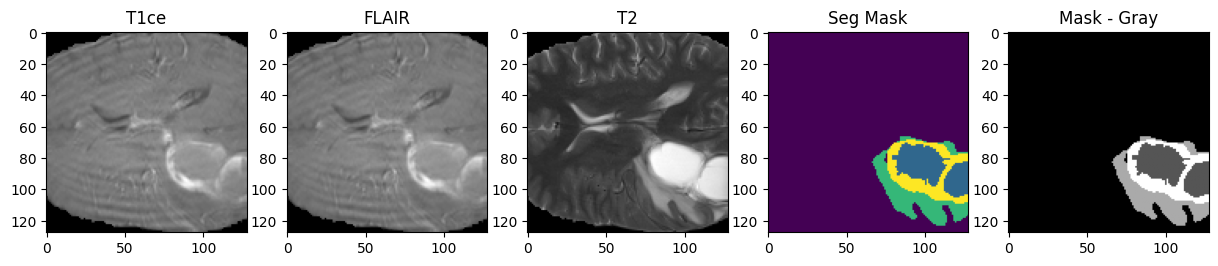

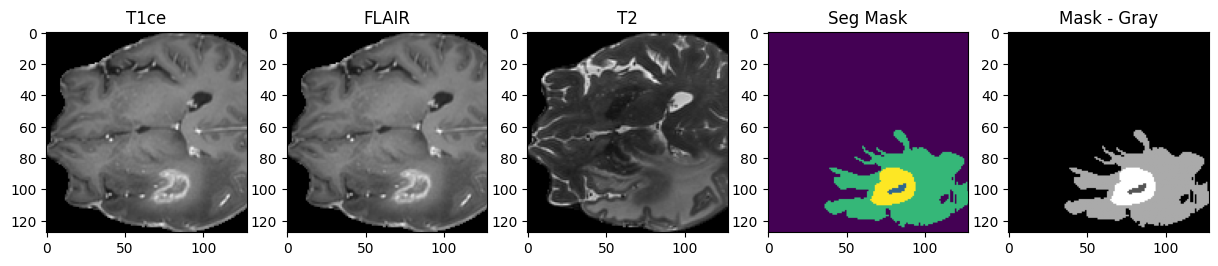

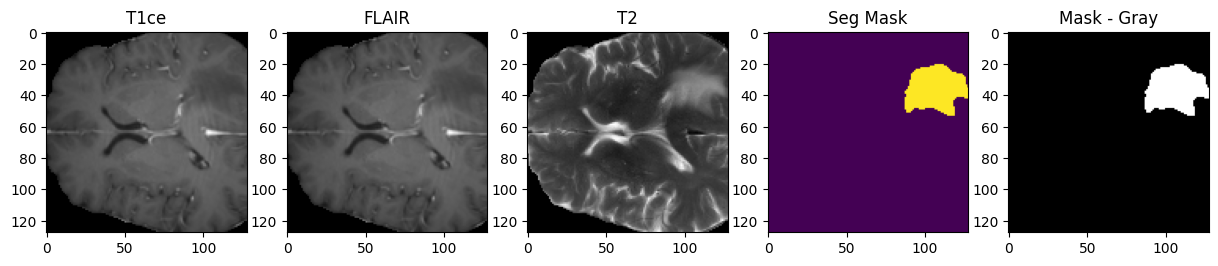

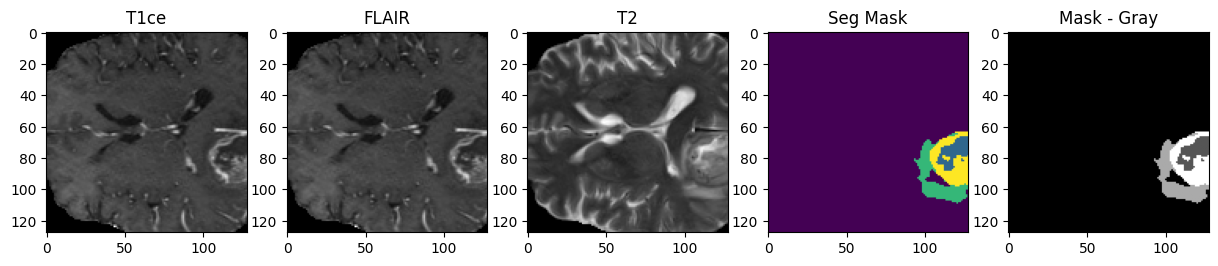

In [37]:
def visualize_slices(images, masks, num_slices=20):
    batch_size = images.shape[0]

    masks = torch.argmax(masks, dim=1)  # along the channel/class dim

    for i in range(min(num_slices, batch_size)):
        fig, ax = plt.subplots(1, 5, figsize=(15, 5))

        middle_slice = images.shape[2] // 2
        ax[0].imshow(images[i, 0, middle_slice, :, :], cmap="gray")
        ax[1].imshow(images[i, 1, middle_slice, :, :], cmap="gray")
        ax[2].imshow(images[i, 2, middle_slice, :, :], cmap="gray")
        ax[3].imshow(masks[i, middle_slice, :, :], cmap="viridis")
        ax[4].imshow(masks[i, middle_slice, :, :], cmap="gray")

        ax[0].set_title("T1ce")
        ax[1].set_title("FLAIR")
        ax[2].set_title("T2")
        ax[3].set_title("Seg Mask")
        ax[4].set_title("Mask - Gray")

        plt.show()


visualize_slices(images, masks, num_slices=20)

## Construire un modèle U-Net 3D : construire un bloc à la fois

On'aurai plus utiliser MONAI et fintunnr un model mais le but ici est de construre un model from scratch

![Texte alternatif](https://learnopencv.com/wp-content/uploads/2024/10/3D-U-Net-Architectuere-Training-from-Scratch-Learning-Dense-Volumetric-Segmentation-from-Sparse-Annotation.png)


In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
   BATCH_SIZE:      int = 2
   EPOCHS:          int = 6
   LEARNING_RATE: float = 1e-3
   CHECKPOINT_DIR:  str = os.path.join('model_checkpoint', '3D_UNet_Brats2023')
   NUM_WORKERS:     int = 0

In [13]:
def double_conv(in_channels, out_channels):
   return nn.Sequential(
       nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
       nn.BatchNorm3d(out_channels),
       nn.ReLU(inplace=True),
       nn.Dropout(0.1 if out_channels <= 32 else 0.2 if out_channels <= 128 else 0.3),
       nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
       nn.BatchNorm3d(out_channels),
       nn.ReLU(inplace=True)
   )

In [14]:
class UNet3D(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()

    # Contraction path
    self.conv1 = double_conv(in_channels=in_channels, out_channels=16)
    self.pool1 = nn.MaxPool3d(kernel_size=2)

    self.conv2 = double_conv(in_channels=16, out_channels=32)
    self.pool2 = nn.MaxPool3d(kernel_size=2)

    self.conv3 = double_conv(in_channels=32, out_channels=64)
    self.pool3 = nn.MaxPool3d(kernel_size=2)

    self.conv4 = double_conv(in_channels=64, out_channels=128)
    self.pool4 = nn.MaxPool3d(kernel_size=2)

    #Encoder
    self.conv5 = double_conv(in_channels=128, out_channels=256)

    #BottleNeck
    self.conv5 = double_conv(in_channels=128, out_channels=256)

    #Decoder or Expansive path
    self.upconv6 = nn.ConvTranspose3d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
    self.conv6 = double_conv(in_channels=256, out_channels=128)

    self.upconv7 = nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
    self.conv7 = double_conv(in_channels=128, out_channels=64)

    self.upconv8 = nn.ConvTranspose3d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
    self.conv8 = double_conv(in_channels=64, out_channels=32)

    self.upconv9 = nn.ConvTranspose3d(in_channels=32, out_channels=16, kernel_size=2, stride=2)
    self.conv9 = double_conv(in_channels=32, out_channels=16)

    self.out_conv = nn.Conv3d(in_channels=16, out_channels=out_channels, kernel_size=1)

  def forward(self, x):
    # Contracting path
    c1 = self.conv1(x)
    p1 = self.pool1(c1)

    c2 = self.conv2(p1)
    p2 = self.pool2(c2)

    c3 = self.conv3(p2)
    p3 = self.pool3(c3)

    c4 = self.conv4(p3)
    p4 = self.pool4(c4)  # downscale

    c5 = self.conv5(p4)

    # Expansive path
    u6 = self.upconv6(c5)  # upscale
    u6 = torch.cat([u6, c4], dim=1)  # skip connections along channel dim
    c6 = self.conv6(u6)

    u7 = self.upconv7(c6)
    u7 = torch.cat([u7, c3], dim=1)
    c7 = self.conv7(u7)

    u8 = self.upconv8(c7)
    u8 = torch.cat([u8, c2], dim=1)
    c8 = self.conv8(u8)

    u9 = self.upconv9(c8)
    u9 = torch.cat([u9, c1], dim=1)
    c9 = self.conv9(u9)

    outputs = self.out_conv(c9)

    return outputs

Teston avec un forwad pass pour verifier que on'a bien la bon dimenssion en sortie

In [15]:
# Test the model
model = UNet3D(in_channels=3, out_channels=4)
print(model)

# Create a random input tensor
ip_tensor = torch.randn(1, 3, 128, 128, 128)

# Forward pass through the model
output = model(ip_tensor)

# Print input and output shapes
print("-" * 260)
print(f"Input shape: {ip_tensor.shape}")
print(f"Output shape: {output.shape}")
total_params = sum(p.numel() for p in model.parameters())
print(f"Nombre total de paramètres : {total_params}")


UNet3D(
  (conv1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

## Definition de la fonction perte et optimizer pour la segmentation de notre models Pytorch


 les pertes basées sur la région comme Dice+Cross Entropy fonctionnent bien. Cependant, si l'ensemble de données est fortement déséquilibré comme dans notre cas, nous pouvons combiner des fonctions de perte basées sur la région (Dice) et sur la distribution (Focal) pour une convergence optimale. Le package smp possède un ensemble de fonctions de perte prédéfinies pour répondre à cet objectif.


$$ \mathcal{L}_{\text{Dice}} = 1 - \frac{2 \sum v_i y_i + \epsilon}{\sum v_i + \sum y_i + \epsilon} $$

$$ \mathcal{L}_{\text{Focal}} = -\sum_{c=1}^{C} \alpha_c \cdot (1 - p_c)^\gamma \cdot y_c \cdot \log(p_c)  $$

In [16]:
dice_loss = smp.losses.DiceLoss(
   mode="multiclass",          # For multi-class segmentation
   classes=None,               # Compute the loss for all classes
   log_loss=False,             # Do not use log version of Dice loss
   from_logits=True,           # Model outputs are raw logits
   smooth=1e-5,                # A small smoothing factor for stability
   ignore_index=None,          # Don't ignore any classes
   eps=1e-7                    # Epsilon for numerical stability
)

# Focal Loss with optional class balancing via alpha
focal_loss = smp.losses.FocalLoss(
   mode="multiclass",          # Multi-class segmentation
   alpha=0.25,                 # class weighting to deal with class imbalance
   gamma=2.0                   # Focusing parameter for hard-to-classify examples
)

def combined_loss(output, target):
   loss1 = dice_loss(output, target)
   loss2 = focal_loss(output, target)
   return loss1 + loss2

Important de suiveiller les poids du model et avoir une annalyse fine des métrique

In [17]:
def create_checkpoint_dir(checkpoint_dir):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    try:
        num_versions = [
            int(i.split("_")[-1]) for i in os.listdir(checkpoint_dir) if "version" in i
        ]
        version_num = max(num_versions) + 1

    except:
        version_num = 0

    version_dir = os.path.join(checkpoint_dir, "version_" + str(version_num))
    os.makedirs(version_dir)

    print(f"Checkpoint directory: {version_dir}")
    return version_dir

In [18]:
seed_everything(SEED = 42)

DEVICE, GPU_AVAILABLE  = get_default_device()
print(DEVICE)

CKPT_DIR = create_checkpoint_dir(TrainingConfig.CHECKPOINT_DIR)

from torch.optim import AdamW

optimizer = AdamW(
   model.parameters(),
   lr=TrainingConfig.LEARNING_RATE,
   weight_decay=1e-2,                # Regularization to avoid overfitting
   amsgrad=True                      # Optional AMSGrad variant
)

cpu
Checkpoint directory: model_checkpoint\3D_UNet_Brats2023\version_2


## Entrainement du model: Train et validation

In [19]:
def train_one_epoch(
   model,
   loader,
   optimizer,
   num_classes,
   device="cpu",
   epoch_idx=800,
   total_epochs=50):

   model.train()

   loss_record = MeanMetric()
   metric_record = MeanMetric()
   acc_record = MulticlassAccuracy(num_classes=num_classes, average='macro')  # Use macro-average accuracy

   loader_len = len(loader)

   with tqdm(total=loader_len, ncols=122) as tq:
       tq.set_description(f"Train ::  Epoch: {epoch_idx}/{total_epochs}")

       for data, target in loader:
           tq.update(1)

           data, target = data.to(device).float(), target.to(device).float()

           optimizer.zero_grad()

           output_dict = model(data)

           target = target.argmax(dim=1)  # Convert one-hot to class indices

           clsfy_out = output_dict  # classifier head output

           loss = combined_loss(clsfy_out, target)

           # Calculate gradients w.r.t training parameters
           loss.backward()
           optimizer.step()

           # Detach for evaluation
           with torch.no_grad():
               pred_idx = clsfy_out.argmax(dim=1)

               # Calculate stats and IoU
               tp, fp, fn, tn = smp.metrics.get_stats(pred_idx, target, mode='multiclass', num_classes=num_classes)

               # Macro IoU and class-wise IoU
               metric_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')

               acc_record.update(pred_idx.cpu(), target.cpu())
               loss_record.update(loss.detach().cpu(), weight=data.shape[0])
               metric_record.update(metric_macro.cpu(), weight=data.shape[0])

           tq.set_postfix_str(s=f"Loss: {loss_record.compute():.4f}, IoU: {metric_record.compute():.4f}, Acc: {acc_record.compute():.4f}")

   epoch_loss = loss_record.compute()
   epoch_metric = metric_record.compute()
   epoch_acc = acc_record.compute()

   return epoch_loss, epoch_metric, epoch_acc

In [20]:

# Validation function, logging macro IoU and per-class IoU.
def validate(
   model,
   loader,
   device,
   num_classes,
   epoch_idx,
   total_epochs
):
   model.eval()


   loss_record = MeanMetric()
   metric_record = MeanMetric()
   acc_record = MulticlassAccuracy(num_classes=num_classes, average='macro')

   loader_len = len(loader)

   with tqdm(total=loader_len, ncols=122) as tq:
       tq.set_description(f"Valid :: Epoch: {epoch_idx}/{total_epochs}")

       for data, target in loader:
           tq.update(1)

           data, target = data.to(device).float(), target.to(device).float()

           with torch.no_grad():
               output_dict = model(data)

           clsfy_out = output_dict
           target = target.argmax(dim=1)  # Convert one-hot to class indices

           loss = combined_loss(clsfy_out, target)
           pred_idx = clsfy_out.argmax(dim=1)

           tp, fp, fn, tn = smp.metrics.get_stats(pred_idx, target, mode='multiclass', num_classes=num_classes)

           # Macro IoU
           metric_macro = smp.metrics.iou_score(tp, fp, fn, tn, reduction='macro')

           acc_record.update(pred_idx.cpu(), target.cpu())
           loss_record.update(loss.cpu(), weight=data.shape[0])
           metric_record.update(metric_macro.cpu(), weight=data.shape[0]) #data.shape = batch

       valid_epoch_loss = loss_record.compute()
       valid_epoch_metric = metric_record.compute()
       valid_epoch_acc = acc_record.compute()

   return valid_epoch_loss, valid_epoch_metric, valid_epoch_acc

In [21]:

# Main function with logging and saving model checkpoints.
def main(*, model, optimizer, ckpt_dir, pin_memory=True, device="cpu"):

    total_epochs = TrainingConfig.EPOCHS

    # Move model to the correct device before the loop starts
    model.to(device, non_blocking=True)

    writer = SummaryWriter(log_dir=os.path.join(ckpt_dir, "tboard_logs"))
    best_loss = float("inf")
    live_plot = PlotLosses(outputs=[MatplotlibPlot(cell_size=(8, 3)), ExtremaPrinter()])

    for epoch in range(total_epochs):
        current_epoch = epoch + 1

        torch.cuda.empty_cache()
        gc.collect()

        # Train one epoch
        train_loss, train_metric, train_acc = train_one_epoch(
            model=model,
            loader=train_loader,
            optimizer=optimizer,
            num_classes=4,
            device=device,
            epoch_idx=current_epoch,
            total_epochs=total_epochs,
        )

        # Validate after each epoch
        valid_loss, valid_metric, valid_acc = validate(
            model=model,
            loader=val_loader,
            device=device,
            num_classes=4,
            epoch_idx=current_epoch,
            total_epochs=total_epochs,
        )

        # Update live plot
        live_plot.update(
            {
                "loss": train_loss,
                "val_loss": valid_loss,
                "accuracy": train_acc,
                "val_accuracy": valid_acc,
                "IoU": train_metric,
                "val_IoU": valid_metric,
            }
        )

        live_plot.send()

        # Write training and validation metrics to TensorBoard
        writer.add_scalar("Loss/train", train_loss, current_epoch)
        writer.add_scalar("Loss/valid", valid_loss, current_epoch)
        writer.add_scalar("Accuracy/train", train_acc, current_epoch)
        writer.add_scalar("Accuracy/valid", valid_acc, current_epoch)
        writer.add_scalar("IoU/train", train_metric, current_epoch)
        writer.add_scalar("IoU/valid", valid_metric, current_epoch)

        # Save the model if validation loss improves
        if valid_loss < best_loss:
            best_loss = valid_loss
            print("Model Improved. Saving...", end="")

            checkpoint_dict = {
                "opt": optimizer.state_dict(),
                "model": model.state_dict(),
            }
            torch.save(checkpoint_dict, os.path.join(ckpt_dir, "ckpt.tar"))
            del checkpoint_dict
            print("Done.\n")

    writer.close()
    return

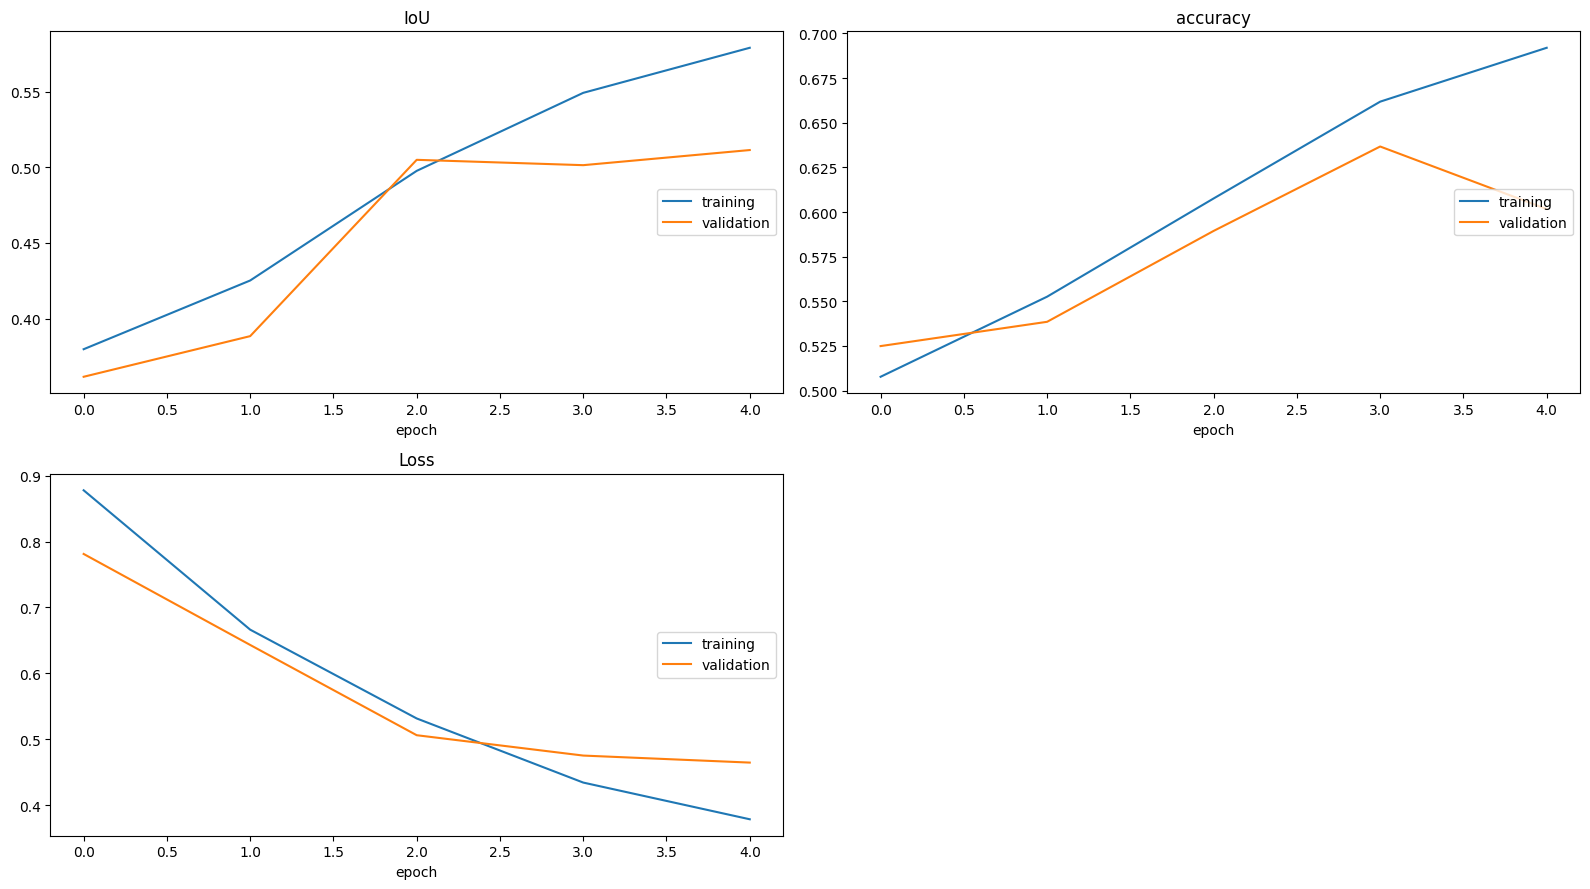

IoU
	training         	 (min:    0.380, max:    0.579, cur:    0.579)
	validation       	 (min:    0.362, max:    0.511, cur:    0.511)
accuracy
	training         	 (min:    0.508, max:    0.692, cur:    0.692)
	validation       	 (min:    0.525, max:    0.637, cur:    0.602)
Loss
	training         	 (min:    0.378, max:    0.878, cur:    0.378)
	validation       	 (min:    0.464, max:    0.781, cur:    0.464)
Model Improved. Saving...Done.

Done.



In [22]:
main(
   model = model,
   optimizer = optimizer,
   ckpt_dir = CKPT_DIR,
   device  = DEVICE,
   pin_memory = GPU_AVAILABLE
)

## Charger le meilleur model

In [23]:
DEVICE, GPU_AVAILABLE = get_default_device()
trained_model = UNet3D(in_channels = 3, out_channels = 4)
trained_model.load_state_dict(torch.load("model_checkpoint/3D_UNet_Brats2023/version_2/ckpt.tar", map_location = DEVICE)['model'])
trained_model.to(DEVICE)
trained_model.eval()

UNet3D(
  (conv1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
  )
  (pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

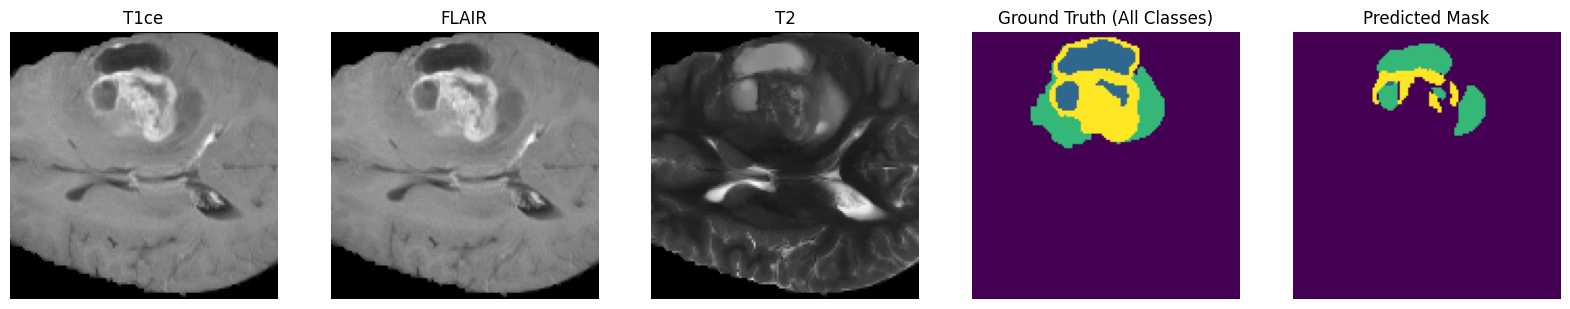

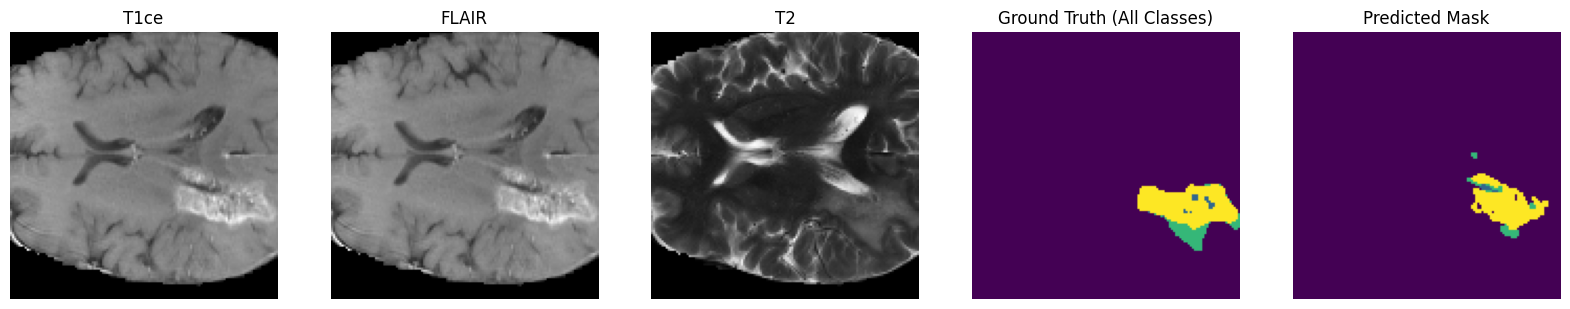

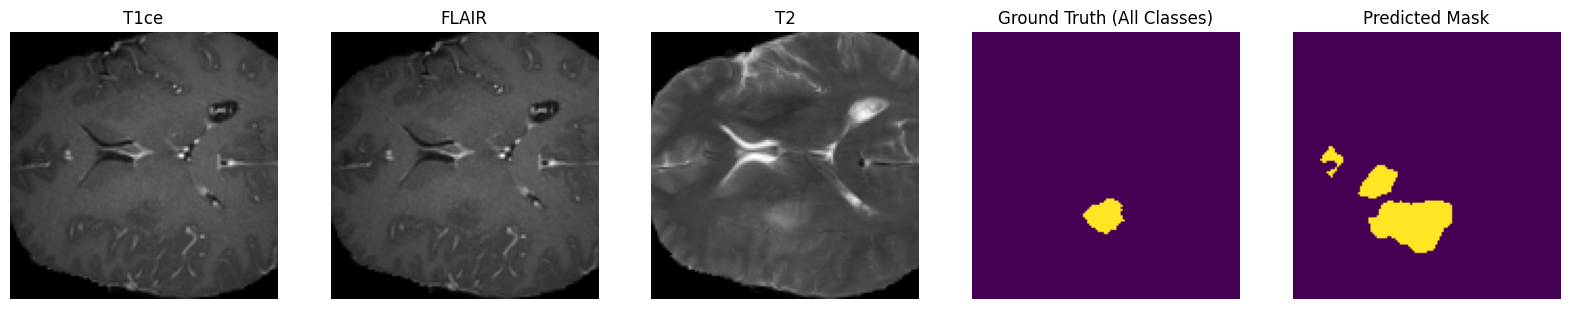

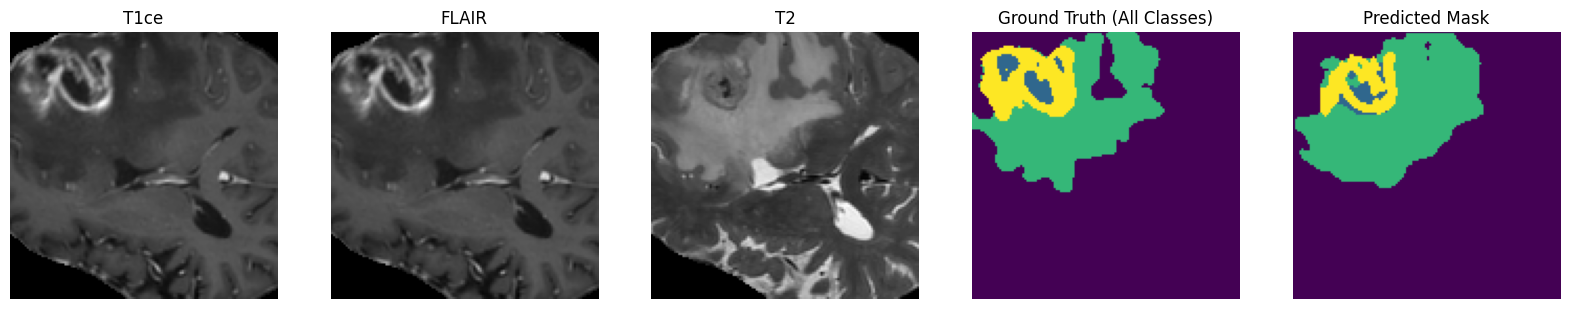

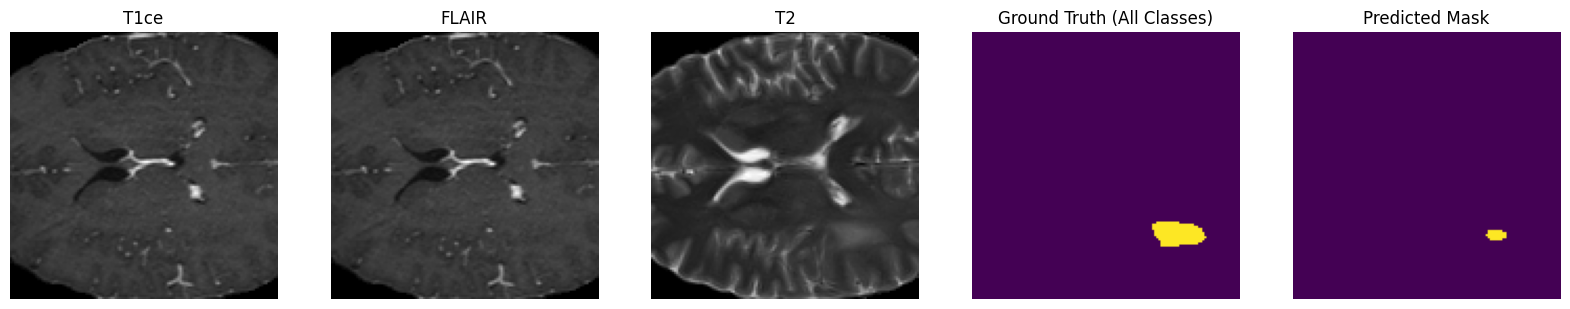

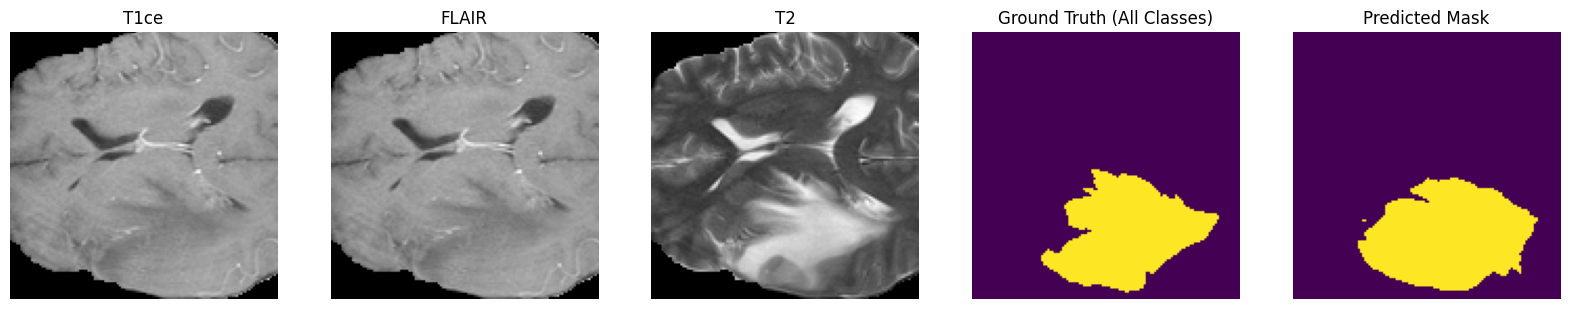

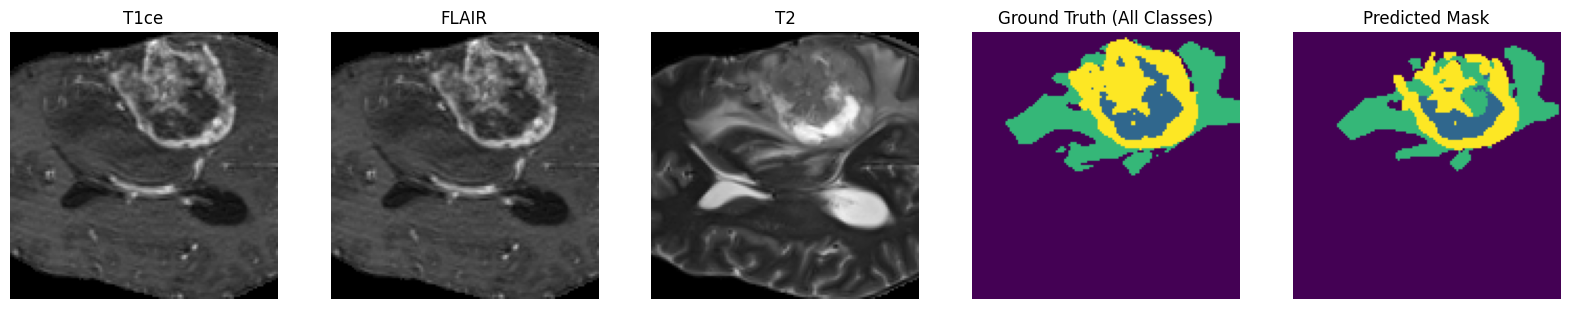

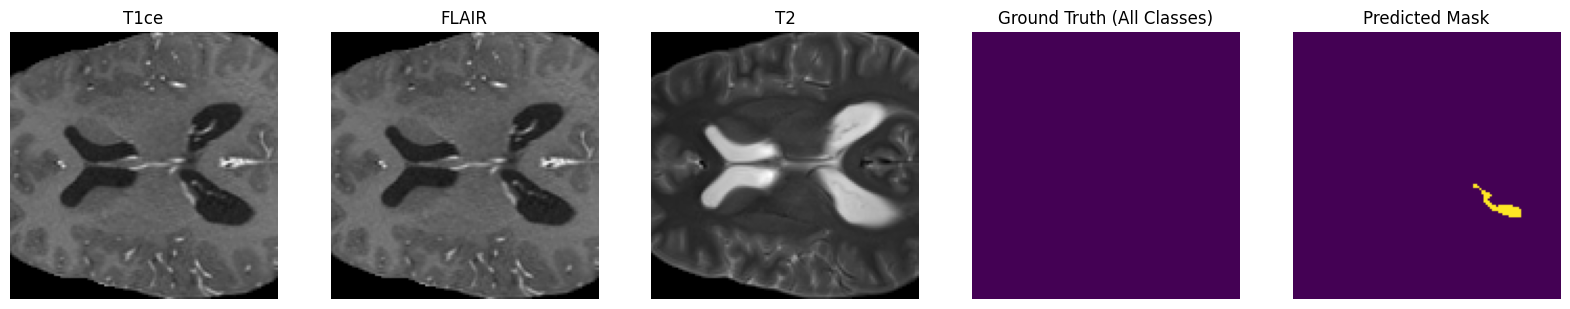

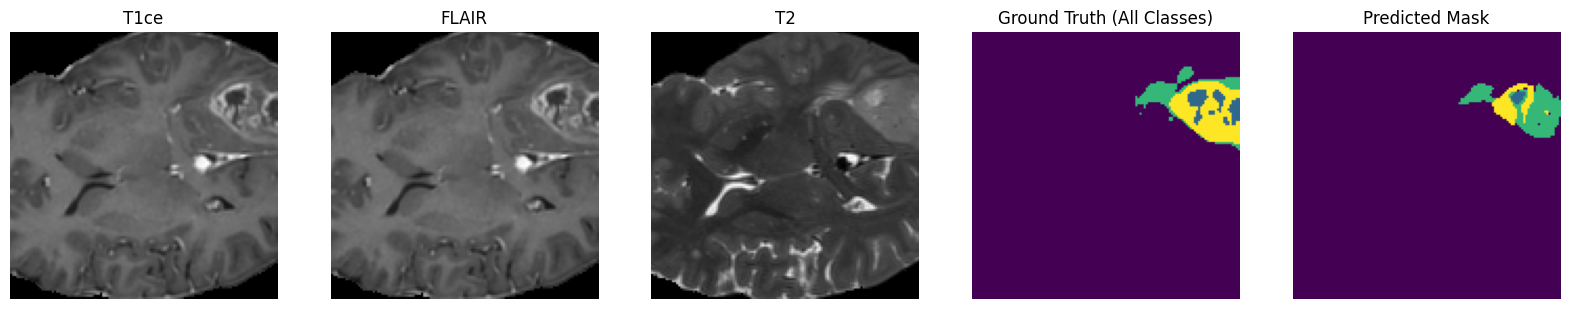

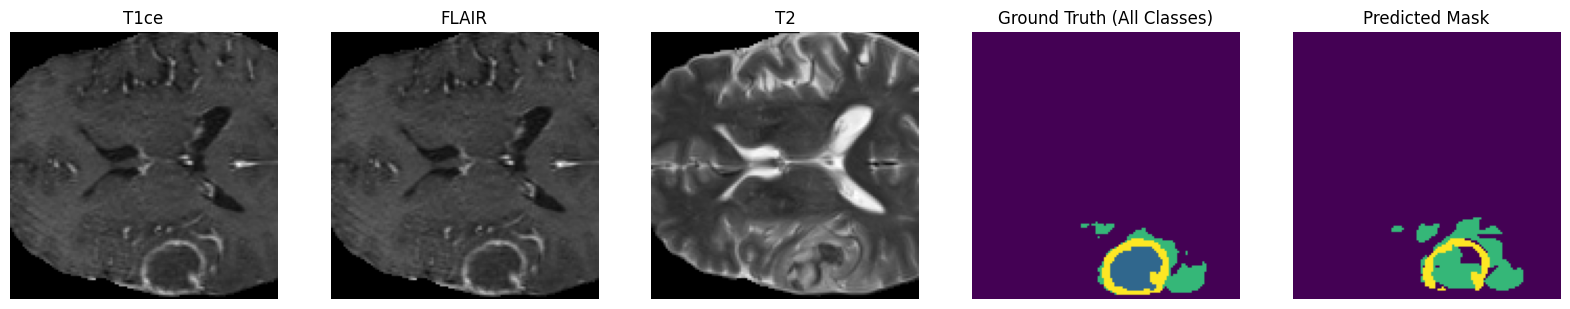

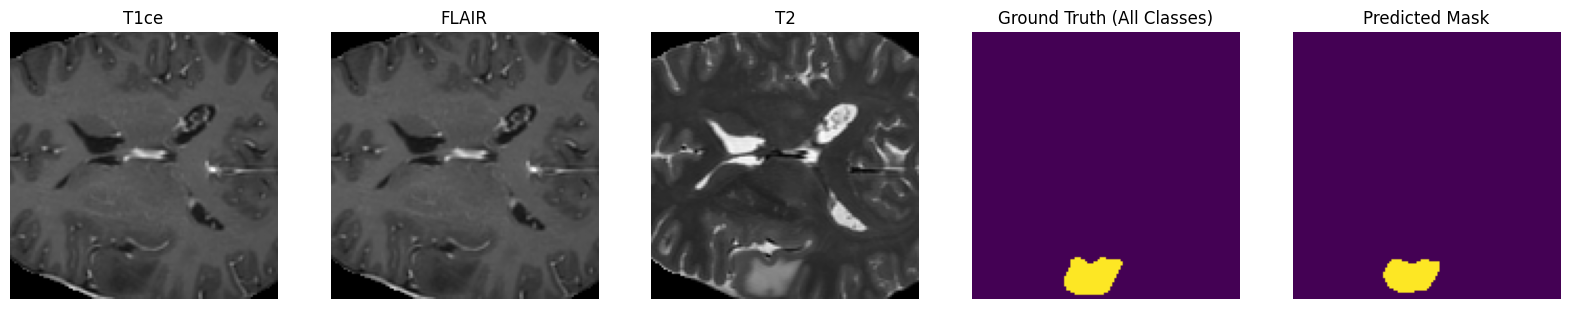

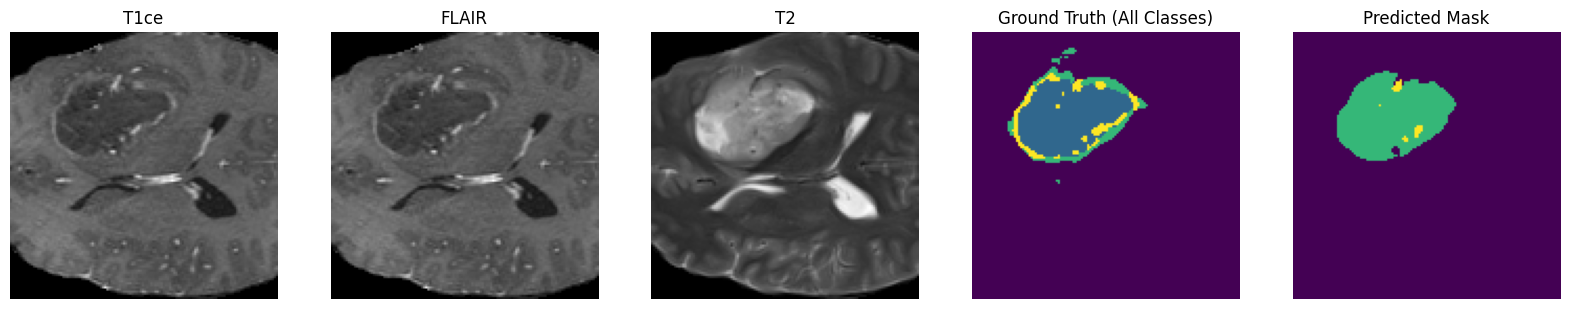

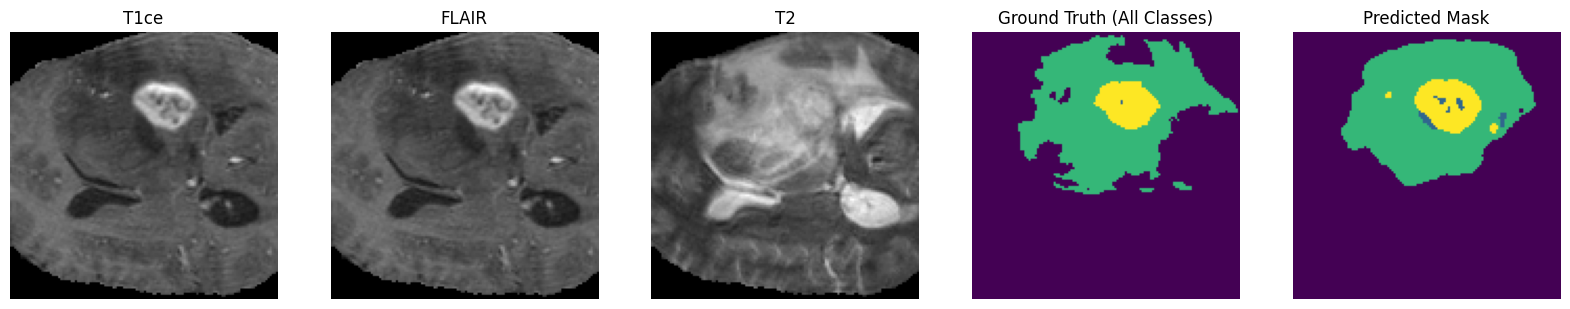

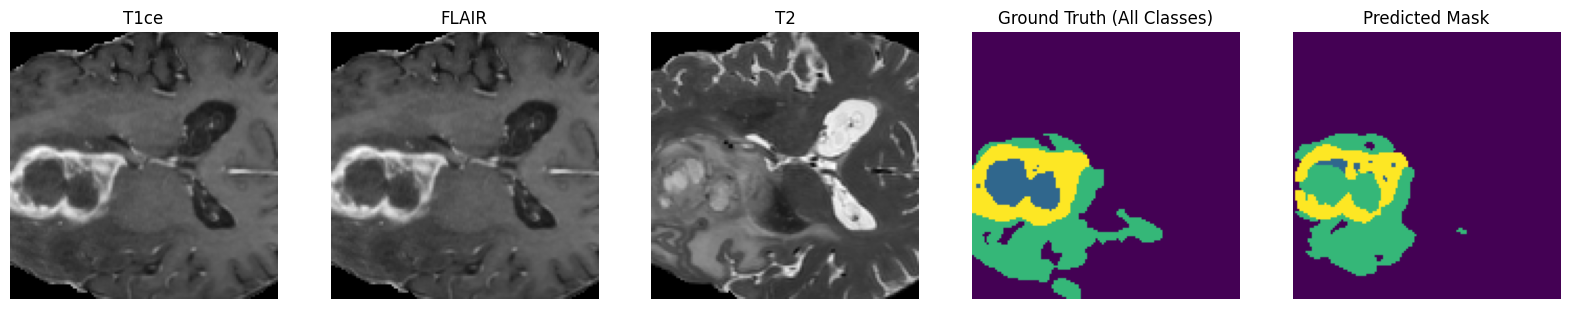

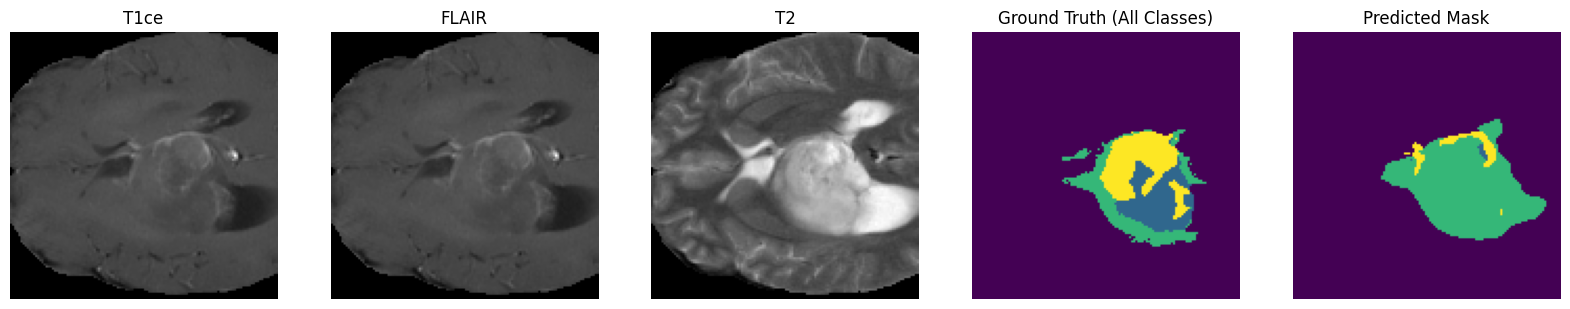

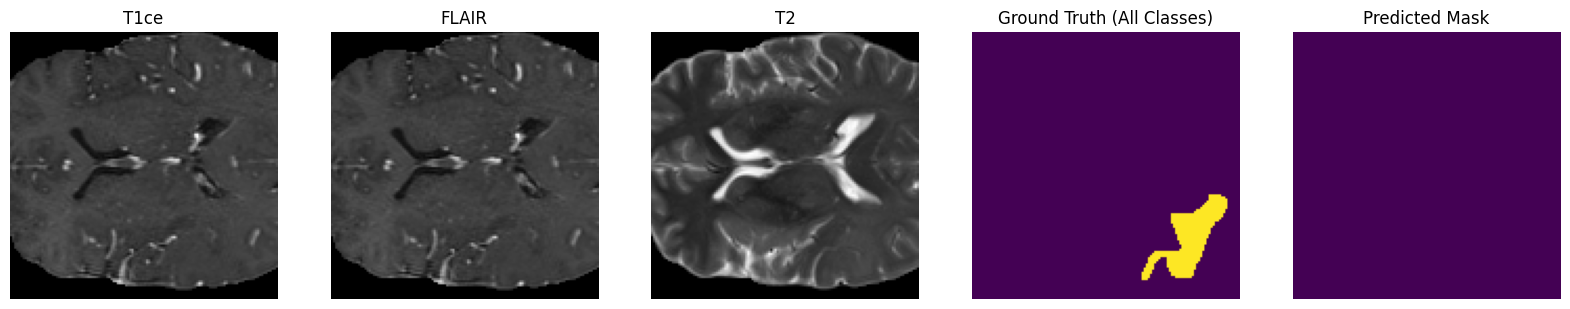

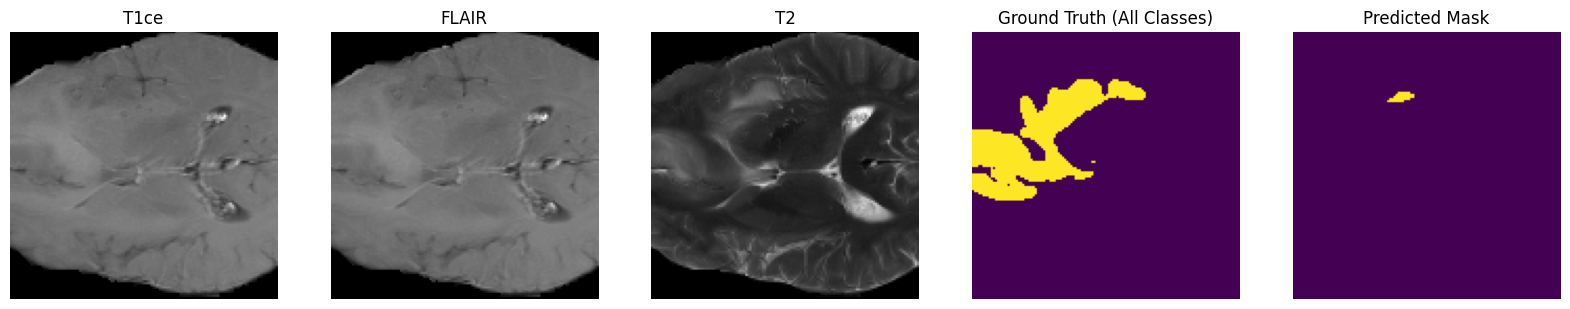

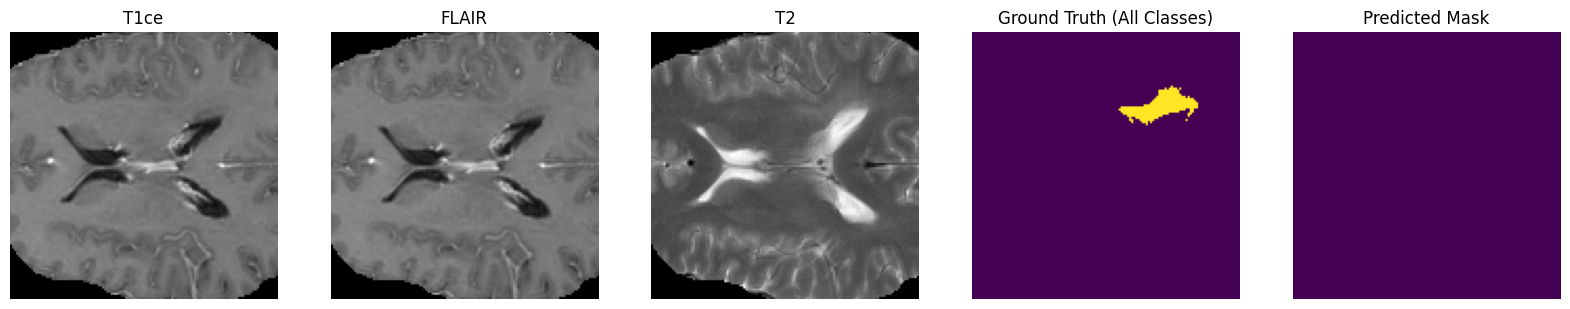

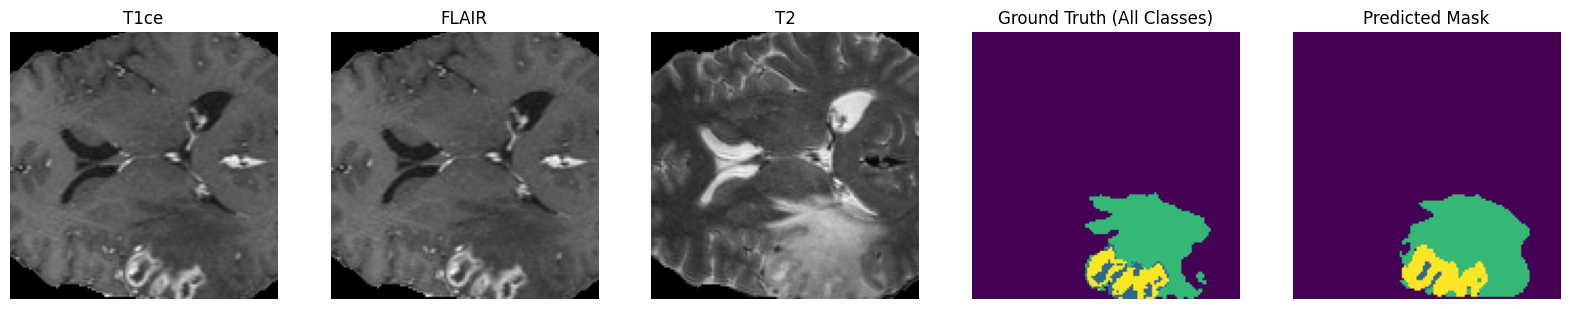

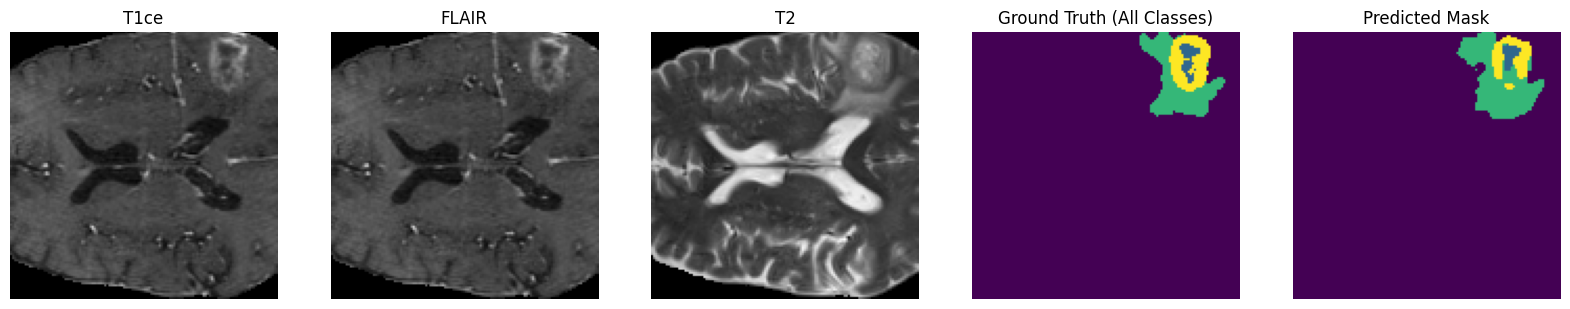

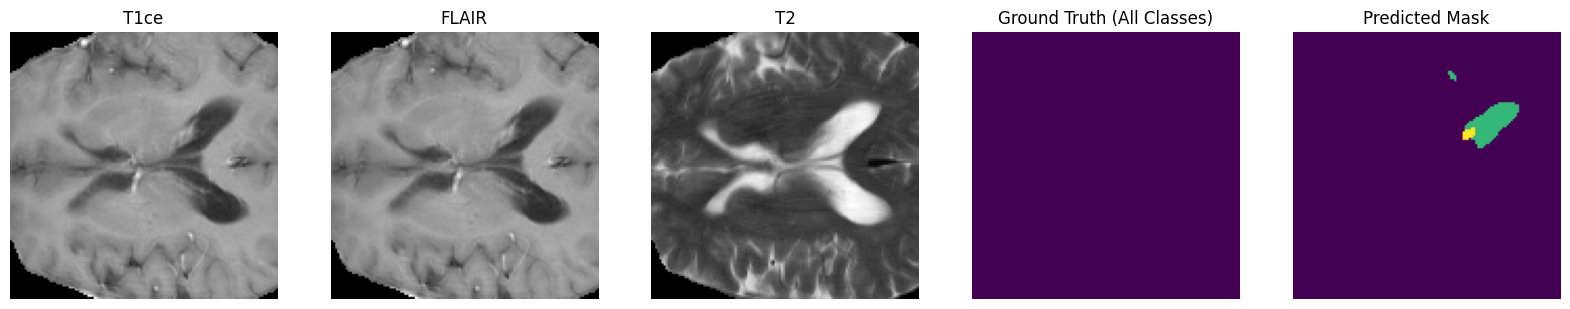

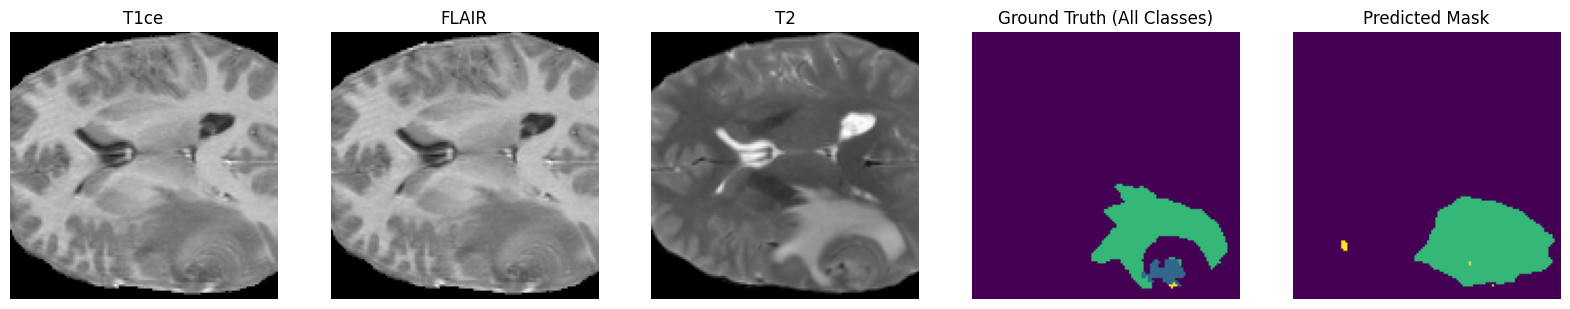

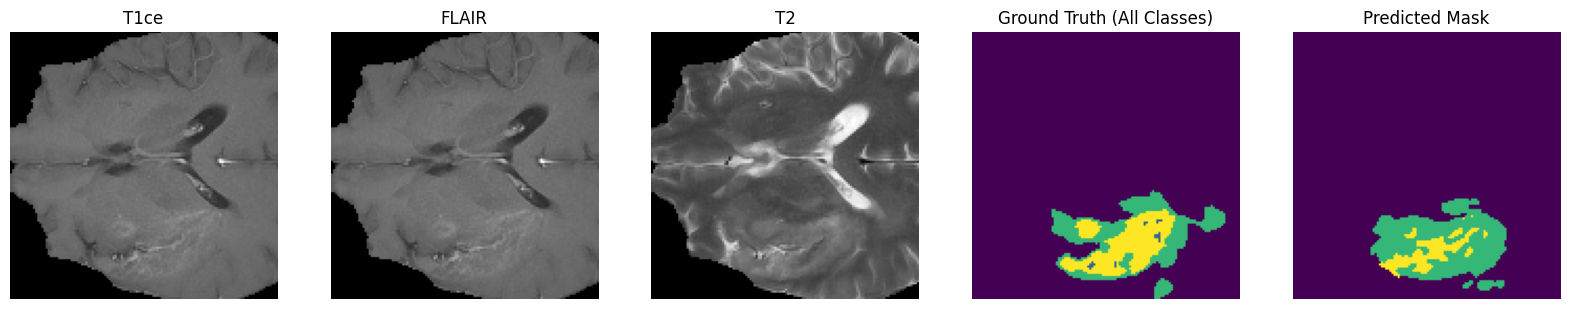

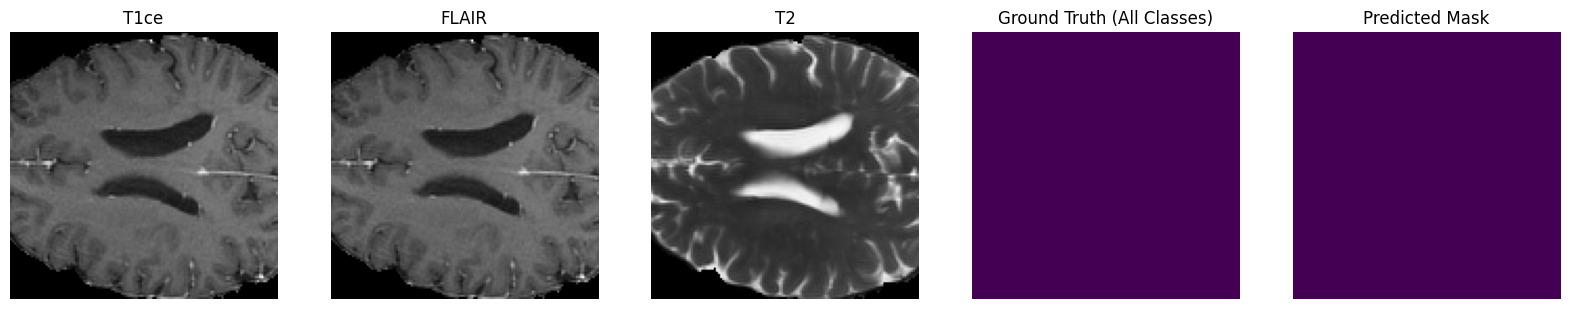

In [25]:
@torch.inference_mode()
def inference(model, loader, device="cpu", num_batches_to_process=8):
    for idx, (batch_img, batch_mask) in enumerate(loader):

        # Move batch images to the device (CPU or GPU)
        batch_img = batch_img.to(device).float()
        # Get the predictions from the model
        pred_all = model(batch_img)

        # Move the predictions to CPU and apply argmax to get predicted classes
        pred_all = pred_all.cpu().argmax(dim=1).numpy()
        # Optionally break after processing a fixed number of batches
        if idx == num_batches_to_process:
            break

        # Visualize images and predictions
        for i in range(0, len(batch_img)):
            fig, ax = plt.subplots(1, 5, figsize=(20, 8))
            middle_slice = batch_img.shape[2] // 2  # Along Depth
            # Visualize different modalities (e.g., T1ce, FLAIR, T2)
            ax[0].imshow(batch_img[i, 0, middle_slice, :, :].cpu().numpy(), cmap="gray")
            ax[1].imshow(batch_img[i, 1, middle_slice, :, :].cpu().numpy(), cmap="gray")
            ax[2].imshow(batch_img[i, 2, middle_slice, :, :].cpu().numpy(), cmap="gray")

            # Get the ground truth mask as class indices using argmax (combine all classes)
            gt_combined = (
                batch_mask[i, :, middle_slice, :, :].argmax(dim=0).cpu().numpy()
            )

            # Visualize the ground truth mask
            ax[3].imshow(gt_combined, cmap="viridis")
            ax[3].set_title("Ground Truth (All Classes)")
            # Visualize the predicted mask
            ax[4].imshow(pred_all[i, middle_slice, :, :], cmap="viridis")
            ax[4].set_title("Predicted Mask")

            # Set titles for the image subplot
            ax[0].set_title("T1ce")
            ax[1].set_title("FLAIR")
            ax[2].set_title("T2")

            # Turn off axis for all subplots
            for a in ax:
                a.axis("off")
            # Show the plot
            plt.show()


# Run inference
inference(model, val_loader, device="cpu", num_batches_to_process=12)
